Put realistic garbage in photos. Start with the simplest one, a paper on the road  
I first need to start by finding where I can place my garbage  
This notebook will work on placement logic

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
from mtrain.data_prep.prep_crops import PrepareCrops
from mtrain.synth.v1 import copy_at
import json
import numpy as np

In [3]:
DATASETS = Path("/Users/hariomnarang/Desktop/personal/roads/datasets")
EXP_BASE = DATASETS / "T003-extract-and-place-on-backdrops-manually"
IMAGES = EXP_BASE / "images"
BACKDROPS = EXP_BASE / "backdrops"
CROPS = EXP_BASE / "crops"

In [4]:
crops = list(PrepareCrops(CROPS).get_all_existing_crops())
bdps = list(BACKDROPS.glob("*.jpeg"))

In [5]:
def alpha_blend(background, foreground, alpha: float):
    """
    background: HxWx3
    foreground: HxWx3
    alpha: HxW float in [0,1]
    """
    # alpha = np.full_like(foreground, fill_value=alpha)
    return (foreground * alpha + background * (1 - alpha)).astype(np.uint8)


def copy_at(background, frag, start0, start1, alpha=0.9):
    mask = np.any(frag != 0, axis=-1)
    end0 = start0 + mask.shape[0]
    end1 = start1 + mask.shape[1]
    roi = background[start0:end0, start1:end1]
    roi_row_len = roi.shape[0]
    roi_col_len = roi.shape[1]
    mask = mask[:roi_row_len, :roi_col_len]
    frag = frag[:roi_row_len, :roi_col_len]
    # roi[mask] = alpha_blend(roi[mask], frag[mask], alpha)
    roi[mask] = frag[mask]
    return start0, start0 + roi_row_len, start1, start1 + roi_col_len

In [6]:
import cv2
import numpy as np


def shrink_mask(mask, shrink_pixels=5):
    """
    Shrinks the white object in a binary mask by `shrink_pixels` pixels.
    
    Parameters:
        mask : np.ndarray
            Binary mask (1s or 255s for object, 0 for background)
        shrink_pixels : int
            Number of pixels to erode from object edges
    
    Returns:
        np.ndarray
            Shrunk binary mask
    """
    mask_uint8 = (mask > 0).astype(np.uint8) * 255
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (shrink_pixels*2+1, shrink_pixels*2+1))
    eroded_mask = cv2.erode(mask_uint8, kernel, iterations=1)
    eroded_mask = (eroded_mask > 0).astype(np.uint8)
    
    return eroded_mask

def resize_fragment_with_manual_horizon(
    fragment_img,
    fragment_base_y,  # y of fragment base in original image
    fragment_horizon_y,  # horizon y in original fragment image
    target_base_y,  # desired base y in target image
    target_horizon_y,  # horizon y in target image
):
    """
    Resizes fragment so it matches perspective between two images
    using manually provided horizon lines.
    """

    # --- Sanity checks ---
    if fragment_base_y <= fragment_horizon_y:
        raise ValueError("Fragment base must be below fragment horizon")

    if target_base_y <= target_horizon_y:
        raise ValueError("Target base must be below target horizon")

    # --- Perspective scale ---
    scale = (target_base_y - target_horizon_y) / (fragment_base_y - fragment_horizon_y)

    if scale <= 0:
        raise ValueError("Invalid scale computed")

    # --- Resize fragment ---
    new_w = int(fragment_img.shape[1] * scale)
    new_h = int(fragment_img.shape[0] * scale)

    return new_w, new_h, scale

    # return resized, scale


def get_crop_base_y(crop):
    with open(crop.meta) as f:
        content = json.load(f)
    return content["bounding_box"]["r"]


def copy_and_show(bdp, crp, y, x, alpha=0.9):
    img = cv2.imread(bdp) if not isinstance(bdp, np.ndarray) else bdp
    c = cv2.imread(crp) if not isinstance(crp, np.ndarray) else crp
    res = copy_at(img, c, y, x, alpha)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    return res, img

In [7]:
valid_crops = []

In [8]:
valid_crops.append(crops[crop_idx])

NameError: name 'crop_idx' is not defined

In [9]:
from ipywidgets import interact

In [33]:
crop_idx = 12
bdp_idx = 0
target_y = 400
target_x = 200

def approx_horizon(img):
    if isinstance(img, int):
        return (img * 1) // 3
    if isinstance(img, Path) or isinstance(img, str):
        img = cv2.imread(img)
    return (img.shape[0] * 1) // 3

def crop_meta(crop):
    with open(crop.meta) as f:
        return json.load(f)


def show_for_crop(idx):
    cmeta = crop_meta(crops[idx])
    orig_base_y = cmeta["bounding_box"]["r"]
    orig_horizon = approx_horizon(cmeta["original"]["r_len"])
    target_horizon = approx_horizon(bdps[bdp_idx])


    frag = cv2.imread(crops[idx].proc)
    if frag is None:
        print("no processed fragment, can skip")
        return 
    new_w, new_h, _ = resize_fragment_with_manual_horizon(
        frag, orig_base_y, orig_horizon, target_y, target_horizon
    )
    resized = cv2.resize(frag, (new_w, new_h), interpolation=cv2.INTER_NEAREST)

    bdp_img = cv2.imread(bdps[2])
    res = copy_at(bdp_img, resized, 600, 200, 1)
    img = cv2.cvtColor(bdp_img, cv2.COLOR_BGR2RGB)
    _, ax = plt.subplots(1, 3, figsize=(15,10))
    s0, e0, s1, e1 = res
    print("idx", idx)
    ax[0].imshow(bdp_img)
    ax[1].imshow(cv2.imread(crops[idx].raw))
    ax[2].imshow(img[s0:e0, s1:e1])
    plt.show()

In [34]:
import ipywidgets as widgets
from IPython.display import display, clear_output

class ReviewWidget:
    def __init__(self, indices, show_fn):
        self.indices = indices
        self.show_fn = show_fn
        self.results = []
        self.i = 0

        self.accept_btn = widgets.Button(
            description="Accept", button_style="success", icon="check"
        )
        self.reject_btn = widgets.Button(
            description="Reject", button_style="danger", icon="times"
        )

        self.accept_btn.on_click(self.on_accept)
        self.reject_btn.on_click(self.on_reject)

        self.out = widgets.Output()

        self.ui = widgets.VBox([self.accept_btn, self.reject_btn, self.out])

    def on_accept(self, b):
        self.results.append(self.indices[self.i])
        self.next()

    def on_reject(self, b):
        self.next()

    def next(self):
        clear_output(wait=True)
        self.i += 1

        if self.i >= len(self.indices):
            print("✅ Done!")
            print("Accepted indices:", self.results)
            return

        with self.out:
            self.out.clear_output(wait=True)
            self.show_fn(self.indices[self.i])
        display(self.ui)

    def start(self):
        with self.out:
            self.out.clear_output(wait=True)
            self.show_fn(self.indices[self.i])
        display(self.ui)

In [ ]:
rw = ReviewWidget(list(range(len(crops))), show_for_crop)


In [36]:
rw.results

[]

In [37]:
rw.start()

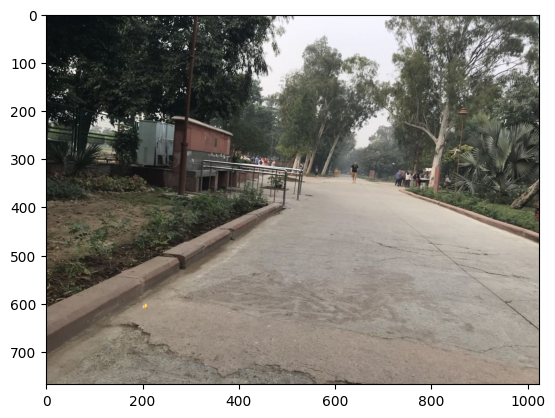

In [84]:
res, img = copy_and_show(bdps[2], resized, 600, 200, 0.5)

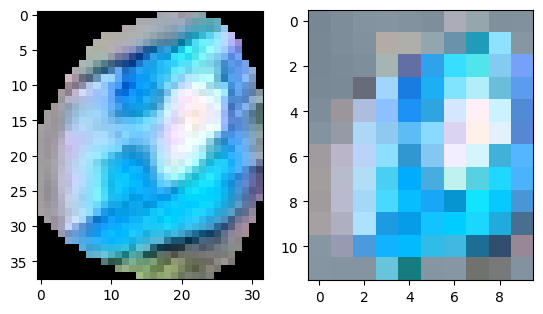

In [85]:
_, ax = plt.subplots(1, 2)
s0, e0, s1, e1 = res
ax[0].imshow(cv2.imread(crops[crop_idx].raw))
ax[1].imshow(img[s0:e0, s1:e1])

# blurred = cv2.blur(img, (1,1))
# nimg = img.copy()
# nimg[s0:e0, s1:e1] = blurred[s0:e0,s1:e1]
# ax[2].imshow(nimg[s0:e0, s1:e1])

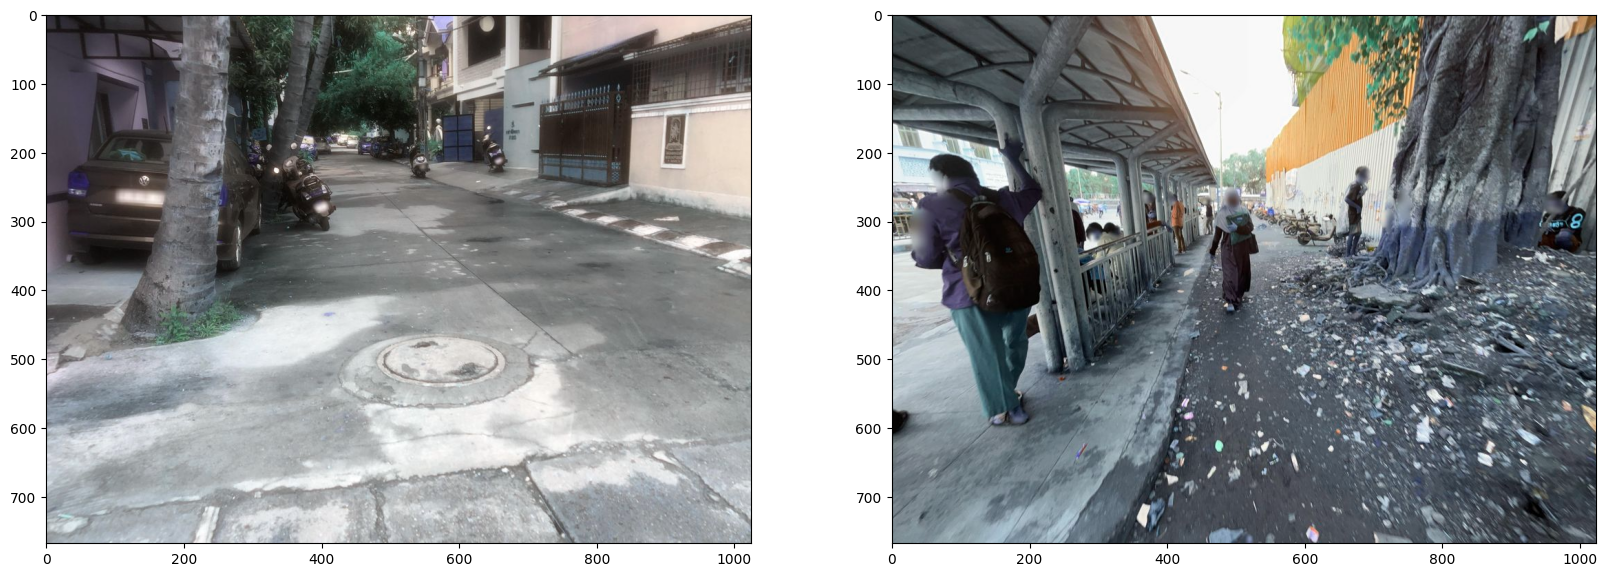

In [251]:

_, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(cv2.imread(bdps[5]))
ax[1].imshow(cv2.imread(orig))